**add some file from github**

In [ ]:
!git clone https://github.com/hoangphu7122002/Yolo-Vehicle-Counter

Cloning into 'Yolo-Vehicle-Counter'...
remote: Enumerating objects: 123, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 123 (delta 29), reused 42 (delta 16), pack-reused 60
Receiving objects: 100% (123/123), 39.90 MiB | 18.13 MiB/s, done.
Resolving deltas: 100% (54/54), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r /content/Yolo-Vehicle-Counter/ /content/drive/MyDrive/vehicle_detection

**get yolo3v.weights**

In [ ]:
!wget -P /content/drive/MyDrive/vehicle_detection/Yolo-Vehicle-Counter/yolo-coco/ https://pjreddie.com/media/files/yolov3.weights

--2022-04-13 14:53:41--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘/content/drive/MyDrive/vehicle_detection/Yolo-Vehicle-Counter/yolo-coco/yolov3.weights.1’

yolov3.weights.1    100%[===================>] 236.52M  33.9MB/s    in 7.6s    

2022-04-13 14:53:48 (31.3 MB/s) - ‘/content/drive/MyDrive/vehicle_detection/Yolo-Vehicle-Counter/yolo-coco/yolov3.weights.1’ saved [248007048/248007048]



**code**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import cv2
import os
from google.colab.patches import cv2_imshow
import imutils

In [ ]:
label_path = "/content/drive/MyDrive/vehicle_detection/Yolo-Vehicle-Counter/yolo-coco/coco.names"

#handle label path
LABELS = open(label_path).read().strip().split("\n")
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),dtype="uint8")

#handle weight path
weightsPath = "/content/drive/MyDrive/vehicle_detection/Yolo-Vehicle-Counter/yolo-coco/yolov3.weights"


#handle config_path
configPath = "/content/drive/MyDrive/vehicle_detection/Yolo-Vehicle-Counter/yolo-coco/yolov3.cfg"

YOLOnet = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

**images_processing**

In [ ]:
ln = YOLOnet.getLayerNames()
ln = [ln[i[0] - 1] for i in YOLOnet.getUnconnectedOutLayers()]

In [ ]:
ln

['yolo_82', 'yolo_94', 'yolo_106']

In [ ]:
image_path = "/content/offset_922706.jpeg"

image = cv2.imread(image_path)
(H, W) = image.shape[:2]

blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416),
	swapRB=True, crop=False)
YOLOnet.setInput(blob)
start = time.time()
layerOutputs = YOLOnet.forward(ln)
end = time.time()
# show timing information on YOLO
print("[INFO] YOLO took {:.6f} seconds".format(end - start))

[INFO] YOLO took 2.660911 seconds


In [ ]:
boxes = []
confidences = []
classIDs = []

for output in layerOutputs:
    for detection in output:
        scores = detection[5:]
        classID = np.argmax(scores)
        confidence = scores[classID]

        if confidence > 0.5:
            box = detection[0:4] * np.array([W, H, W, H])
            centerX, centerY, width, height = box.astype("int")

            x = int(centerX - (width / 2))
            y = int(centerY - (height / 2))

            boxes.append([x, y, int(width), int(height)])
            confidences.append(float(confidence))
            classIDs.append(classID)

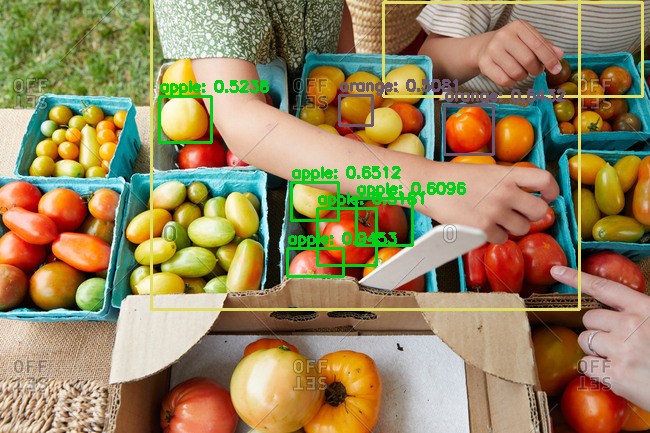

-1

In [ ]:
idxs = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.5)
if len(idxs) > 0:
	for i in idxs.flatten():
		(x, y) = (boxes[i][0], boxes[i][1])
		(w, h) = (boxes[i][2], boxes[i][3])
		color = [int(c) for c in COLORS[classIDs[i]]]
		cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
		text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
		cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
			0.5, color, 2)

cv2_imshow(image)
cv2.waitKey(0)

In [ ]:
vs = cv2.VideoCapture("/content/drive/MyDrive/vehicle_detection/Yolo-Vehicle-Counter/bridge.mp4")
writer = None
(W, H) = (None, None)

prop = cv2.cv.CV_CAP_PROP_FRAME_COUNT if imutils.is_cv2() \
else cv2.CAP_PROP_FRAME_COUNT
total = int(vs.get(prop))
print("[INFO] {} total frames in video".format(total))

[INFO] 576 total frames in video


In [ ]:
while True:
    (grabbed, frame) = vs.read()
    if not grabbed:
		   break
    if W is None or H is None:
		   (H, W) = frame.shape[:2]

    blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (416, 416),
		swapRB=True, crop=False)

    YOLOnet.setInput(blob)
    start = time.time()
    layerOutputs = YOLOnet.forward(ln)
    end = time.time()
    
    boxes = []
    confidences = []
    classIDs = []

    for output in layerOutputs:
        for detection in output:
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]

            if confidence > 0.5:
                box = detection[0:4] * np.array([W, H, W, H])
                centerX, centerY, width, height = box.astype("int")

                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))

                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)

    idxs = cv2.dnn.NMSBoxes(boxes, confidences, 0.9, 0.3)
    if len(idxs) > 0:
      for i in idxs.flatten():
        (x, y) = (boxes[i][0], boxes[i][1])
        (w, h) = (boxes[i][2], boxes[i][3])
        color = [int(c) for c in COLORS[classIDs[i]]]
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
        text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
        cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
          0.5, color, 2) 
    if writer is None:
        fourcc = cv2.VideoWriter_fourcc(*"MJPG")
        writer = cv2.VideoWriter('/content/', fourcc, 30,(frame.shape[1], frame.shape[0]), True)

        if total > 0:
           elap = (end - start)
           print("[INFO] single frame took {:.4f} seconds".format(elap))
           print("[INFO] estimated total time to finish: {:.4f}".format(elap * total))

    writer.write(frame)

print("[INFO] cleaning up...")
writer.release()
vs.release()

[INFO] single frame took 1.9929 seconds
[INFO] estimated total time to finish: 1147.9324
[INFO] cleaning up...


**Streaming**